In [442]:
import torch
import torch.nn as nn
import torch.autograd as autograd
import numpy as np

def grad(model,
         input: torch.Tensor
) -> torch.Tensor:

  params = list(model.parameters())
  model.zero_grad()
  output = model(input)
  output.backward(
      torch.ones_like(output))
  return torch.cat([param.grad.view(-1) for param in params
                    if param.requires_grad])


class NTK():
  def __init__(self,
               model,
               input_loader: torch.Tensor
  ) -> None:

    num_samples = input_loader.tensors[0].shape[0]
    emp_matrix = torch.zeros((num_samples, num_samples))

    grads = [grad(model, input_loader.tensors[0][idx])
             for idx in range(num_samples)]

    for row in range(num_samples):
      for col in range(row, num_samples):
        emp_matrix[row, col] = \
        emp_matrix[col, row] = \
        torch.dot(grads[row], grads[col])

    np_emp_matrix = emp_matrix.numpy()

    self.empirical_matrix = np_emp_matrix
    self.spectrum = np.linalg.eigvalsh(np_emp_matrix)[::-1]

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import scipy as sp

class MLP(nn.Module):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            hidden_layers: int,
            hidden_width: int,
            activ_fn=nn.ReLU
    ) -> None:

        super(MLP, self).__init__()
        layers = []
        cur_dim = input_dim

        for _ in range(hidden_layers):
            layers.append(nn.Linear(cur_dim, hidden_width))
            layers.append(activ_fn())
            cur_dim = hidden_width

        self.hidden_layers = nn.Sequential(*layers)
        self.output_layer = nn.Linear(cur_dim, output_dim)


    def forward(
            self,
            input: torch.Tensor
    ) -> torch.Tensor:

        hidden_output = self.hidden_layers(input)
        return self.output_layer(hidden_output)


    def train(
            model,
            train_loader: torch.Tensor,
            epochs: int,
            learning_rate=0.01
    ) -> None:

        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        for step in range(epochs):
            for in_batch, out_batch in train_loader:
                optimizer.zero_grad()
                outputs = model(in_batch)
                loss = torch.mean((outputs - out_batch) ** 2)
                loss.backward()
                optimizer.step()


class FourierFeatureEmbedding():
    def __init__(
            self,
            input_dim: int,
            num_features: int,
            kernel: str,
            length_scale: float
    ) -> None:
        '''Computes random features for embedding'''

        size = (num_features, input_dim)

        if kernel == 'RBF':
            '''Corresponding spectral kernel is Gaussian with mean=0, variance=1/length_scale**2'''
            random_mat = np.random.normal(loc=0,
                                          scale=1 / length_scale,
                                          size=size)

        if kernel == 'Laplace':
            '''Corresponding spectral kernel is Cauchy with loc=0, scale=1/length_scale'''
            random_mat = sp.stats.cauchy.rvs(loc=0,
                                             scale=1 / length_scale,
                                             size=size)
        self.random_features = random_mat
        self.num_features = num_features


    def embed(
            self,
            input: np.ndarray
    ) -> torch.Tensor:
        '''Embeds a given dataset using the computed random features'''

        cos_mat = np.cos(2 * np.pi * self.random_features @ input.T)
        sin_mat = np.sin(2 * np.pi * self.random_features @ input.T)

        embed_mat = np.concatenate(
            (cos_mat, sin_mat), axis=0).T / np.sqrt(self.num_features)

        return torch.tensor(embed_mat, dtype=torch.float32)

# Imports

In [477]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable
#from ffnet import MLP, FourierFeatureEmbedding
#from ntk import NTK

# Sample Signal Generation

In [476]:
def random_signal(num_coefs: int
) -> Callable[np.ndarray, np.ndarray]:
    '''Computes a linear combo of pure frequencies'''

    sin_coefs = np.random.standard_normal(num_coefs)
    cos_coefs = np.random.standard_normal(num_coefs)

    rand_func = lambda x : \
                  sum(coef * np.sin(np.pi * x / coef)
                      for coef in sin_coefs) + \
                  sum(coef * np.cos(np.pi * x / coef)
                      for coef in cos_coefs)

    return rand_func

In [478]:
samp_num_coefs = 8
samp_signal = random_signal(samp_num_coefs)

# Data Initialization

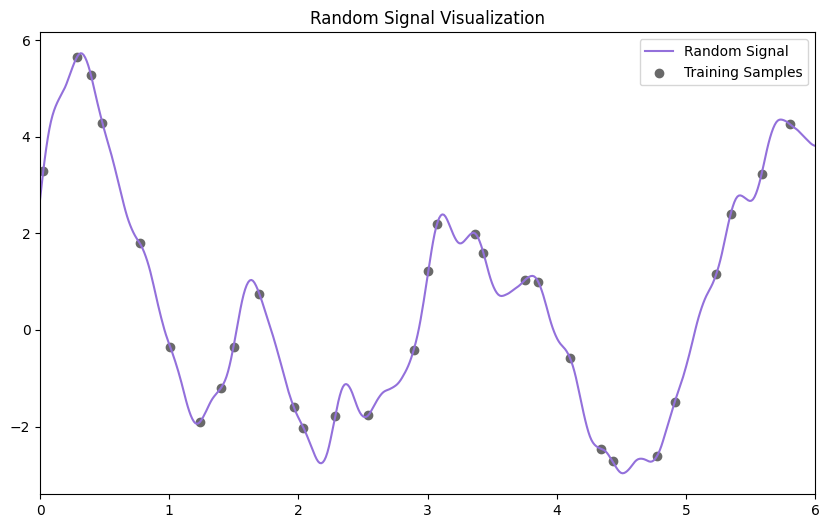

In [479]:
'''Initializing and visualizing sample data'''
input_range = (0, 6)
range_size = input_range[1] - input_range[0]

input_space = np.linspace(input_range[0], input_range[1], 500)
output_space = samp_signal(input_space)

base_input = np.arange(input_range[0], input_range[1], 1 / 5)
num_points = 5 * range_size

train_input = base_input + np.random.normal(0, 0.1, num_points)
test_input = base_input + np.random.normal(0, 0.1, num_points)

train_output = samp_signal(train_input)
test_output = samp_signal(test_input)

plt.figure(figsize=(10, 6))

plt.plot(input_space, output_space,
         linewidth=1.5,
         color='mediumpurple',
         label='Random Signal')

plt.scatter(train_input, train_output,
            color='dimgrey',
            label='Training Samples')

plt.xlim(input_range[0], input_range[1])
plt.legend()
plt.title('Random Signal Visualization')
plt.show()

# Network Initialization

In [489]:
'''Network architecture'''

hidden_layers = 4
hidden_width = 64

output_tens = torch.tensor(train_output,
                           dtype=torch.float32).reshape(-1, 1)

test_output_tens = torch.tensor(test_output,
                                dtype=torch.float32).reshape(-1, 1)

'''Initializing embedding-free data and network'''

base_input_tens = torch.tensor(train_input,
                               dtype=torch.float32).reshape(-1, 1)
base_tens_data = TensorDataset(base_input_tens, output_tens)
base_tens_loader = DataLoader(base_tens_data, batch_size=1, shuffle=True)

base_mlp = MLP(input_dim=1, output_dim=1,
               hidden_layers=hidden_layers,
               hidden_width=hidden_width)

base_test_tens = torch.tensor(test_input,
                               dtype=torch.float32).reshape(-1, 1)

In [490]:
'''Initializing RBF and Laplace embeddings'''

num_rand_features = 6
lengths = [0.5, 0.1]
num_lengths = len(lengths)

rbf_features = [FourierFeatureEmbedding(input_dim=1, num_features=num_rand_features,
                                        kernel='RBF', length_scale=length_scale)
                                        for length_scale in lengths]

laplace_features = [FourierFeatureEmbedding(input_dim=1, num_features=num_rand_features,
                                        kernel='Laplace', length_scale=length_scale)
                                        for length_scale in lengths]

In [491]:
'''Initializing RBF and Laplace networks'''

rbf_input_tens = [rbf_features[idx].embed(train_input.reshape(-1, 1))
                  for idx in range(num_lengths)]

rbf_tens_data = [TensorDataset(rbf_input_tens[idx], output_tens)
                for idx in range(num_lengths)]

rbf_tens_loader = [DataLoader(rbf_tens_data[idx], batch_size=1, shuffle=True)
                for idx in range(num_lengths)]

rbf_mlps = [MLP(input_dim=2 * num_rand_features, output_dim=1,
                hidden_layers=hidden_layers,
                hidden_width=hidden_width)
                for length_scale in lengths]

rbf_test_tens = [rbf_features[idx].embed(test_input.reshape(-1, 1))
                  for idx in range(num_lengths)]


laplace_input_tens = [laplace_features[idx].embed(train_input.reshape(-1, 1))
                  for idx in range(num_lengths)]

laplace_tens_data = [TensorDataset(laplace_input_tens[idx], output_tens)
                for idx in range(num_lengths)]

laplace_tens_loader = [DataLoader(laplace_tens_data[idx], batch_size=1, shuffle=True)
                for idx in range(num_lengths)]

laplace_mlps = [MLP(input_dim=2 * num_rand_features, output_dim=1,
                hidden_layers=hidden_layers,
                hidden_width=hidden_width)
                for length_scale in lengths]

laplace_test_tens = [laplace_features[idx].embed(test_input.reshape(-1, 1))
                  for idx in range(num_lengths)]

# Network Training

In [492]:
'''Training networks'''

num_iters = 250

input_tensors = [base_input_tens] + rbf_input_tens \
              + laplace_input_tens

test_tensors = [base_test_tens] + rbf_test_tens \
             + laplace_test_tens

train_tensors = [base_tens_loader] + rbf_tens_loader \
              + laplace_tens_loader

mlps = [base_mlp] + rbf_mlps + laplace_mlps

num_nets = len(mlps)
train_loss = np.zeros((num_iters, num_nets))
test_loss = np.zeros((num_iters, num_nets))

loss = nn.MSELoss()

for step in range(num_iters):
  for idx in range(num_nets):
    mlps[idx].train(train_tensors[idx], 1)
    temp_train_outs = mlps[idx](input_tensors[idx]).detach()
    temp_test_outs = mlps[idx](test_tensors[idx]).detach()
    train_loss[step, idx] = loss(temp_train_outs, output_tens).item()
    test_loss[step, idx] = loss(temp_test_outs, test_output_tens).item()

# Network Comparison

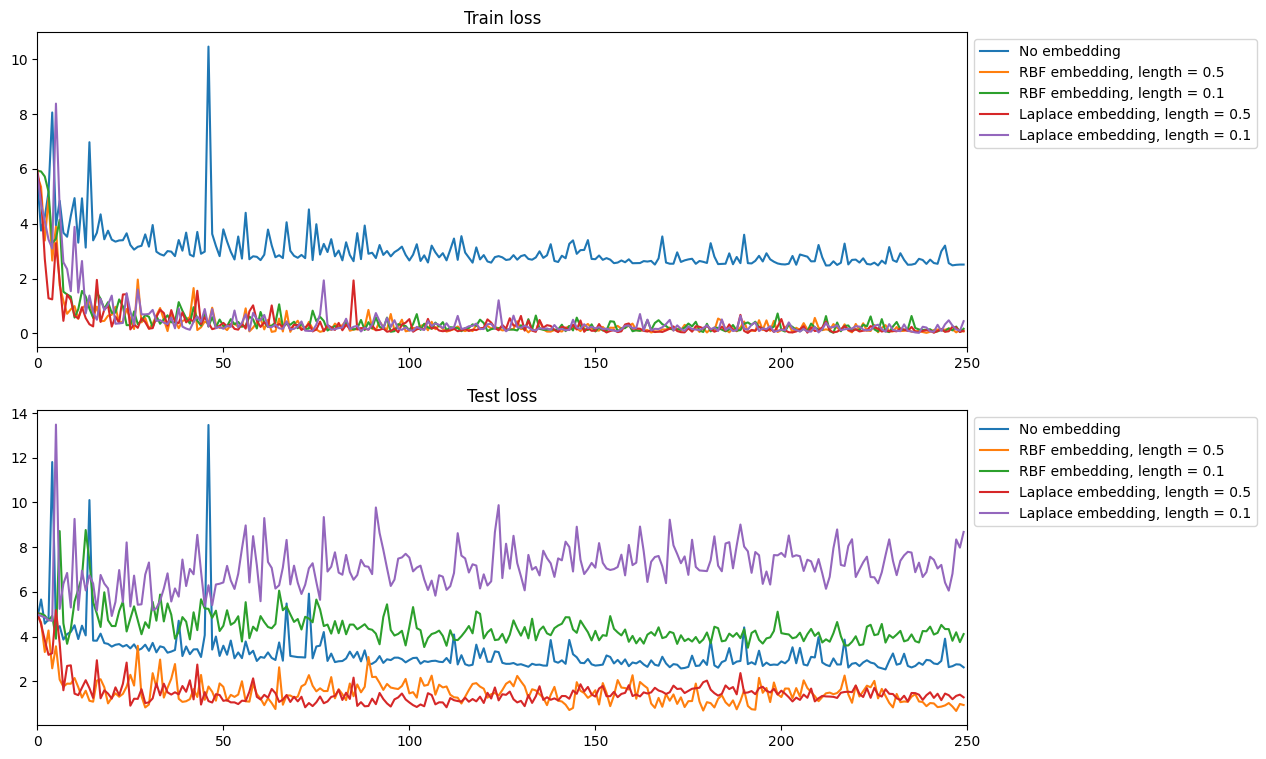

In [493]:
'''Visualizing train, test loss'''

def get_label(idx: int
) -> 'str':
    '''Gets a label for train/test loss visualization'''

    if idx == 0:
      return 'No embedding'

    if num_lengths - idx >= 0:
      return 'RBF embedding, length = ' + str(lengths[idx - 1])

    else:
      return 'Laplace embedding, length = ' \
              + str(lengths[idx - num_lengths - 1])

fig, axs = plt.subplots(2, 1, figsize=(12, 9))

for idx in range(num_nets):
  axs[0].plot(train_loss[:, idx], label=get_label(idx), linewidth=1.5)
  axs[1].plot(test_loss[:, idx], label=get_label(idx), linewidth=1.5)

axs[0].set_title('Train loss')
axs[1].set_title('Test loss')

axs[0].set_xlim(0, num_iters)
axs[1].set_xlim(0, num_iters)

axs[0].legend(loc='upper left', bbox_to_anchor=(1, 1))
axs[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

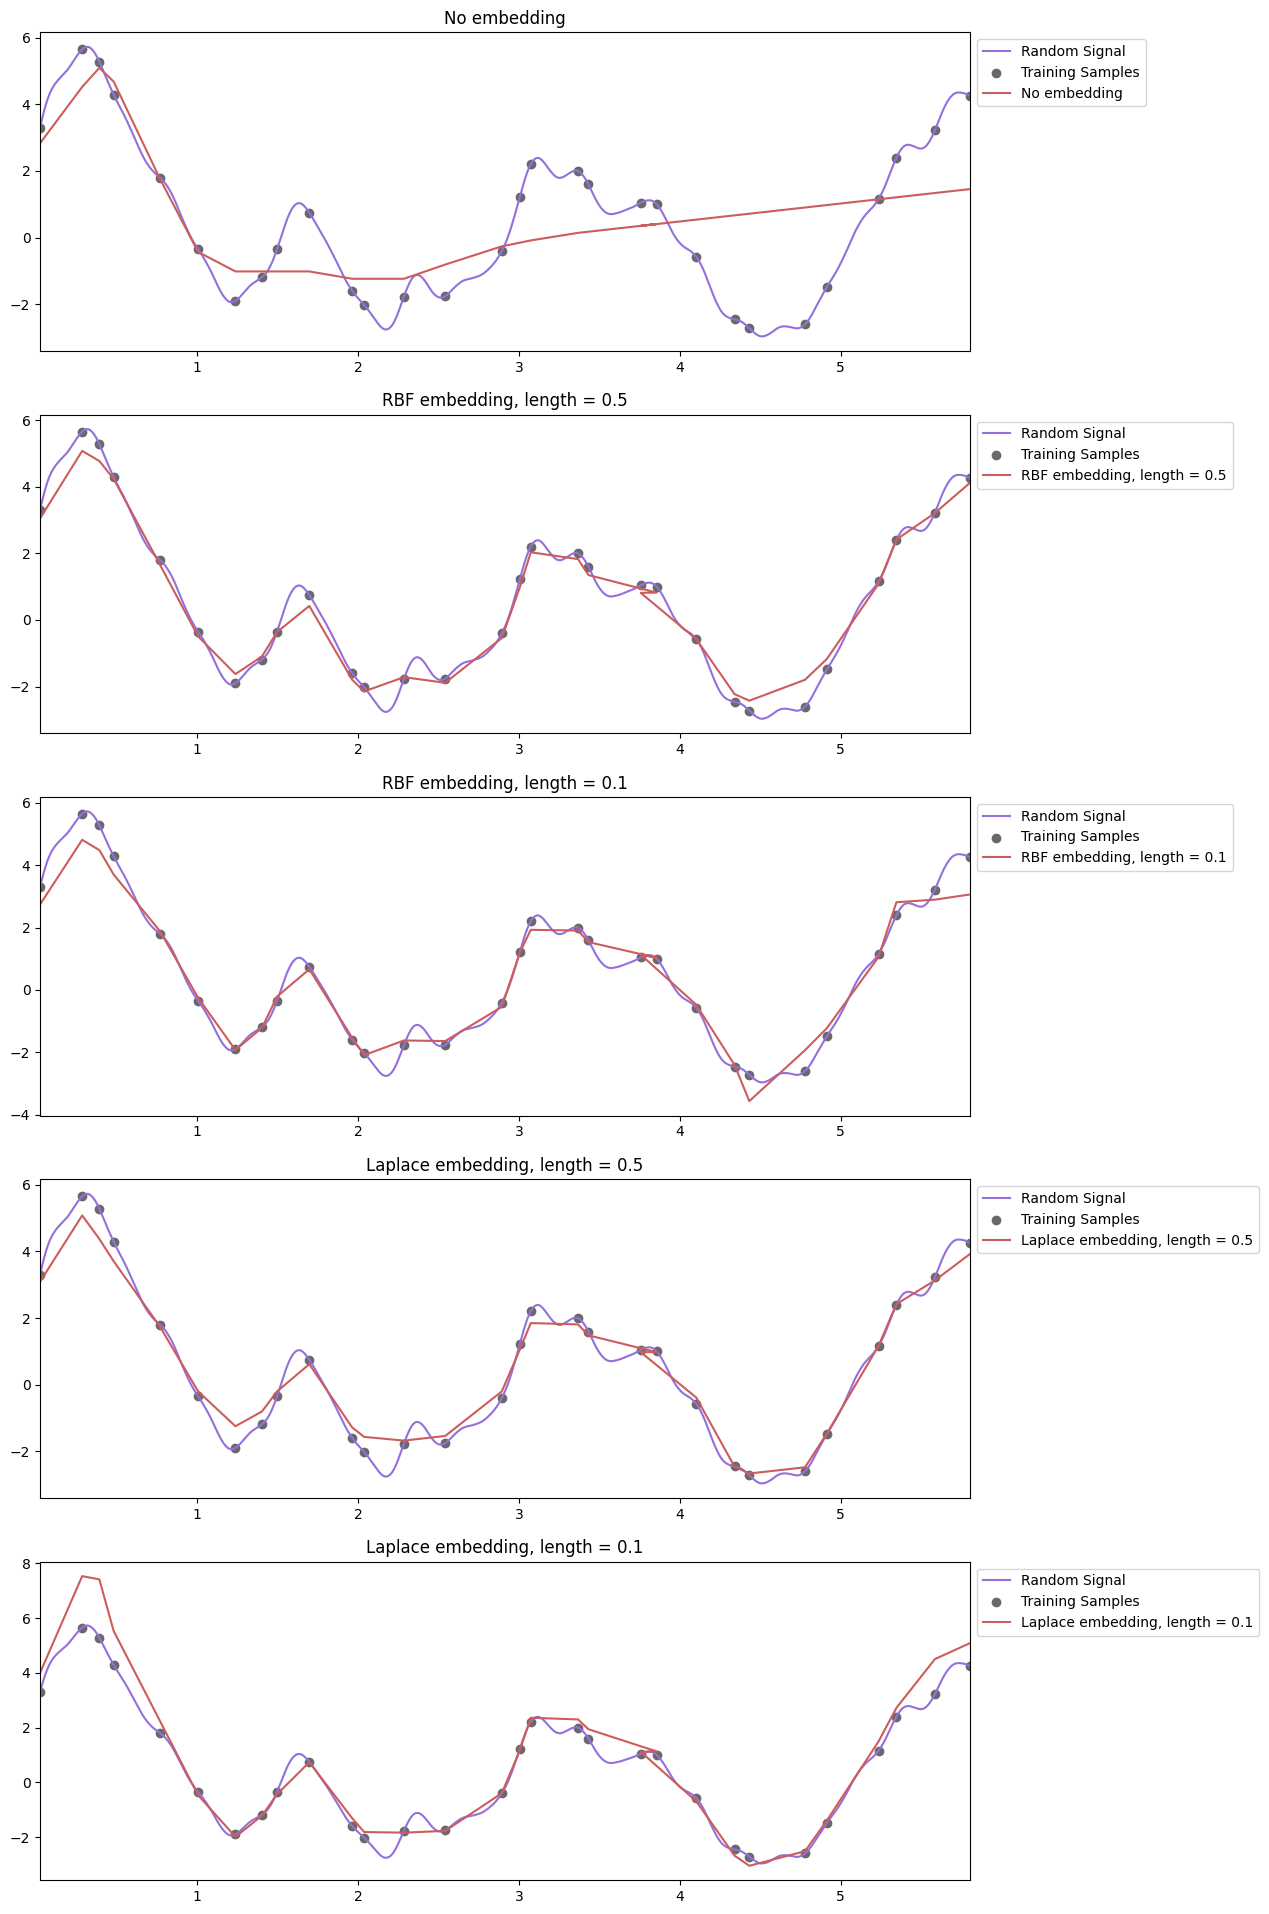

In [494]:
'''Visualizing network predictions'''

figs, axs = plt.subplots(1 + 2 * num_lengths, 1, figsize=(12, 24))

for idx in range(1 + 2 * num_lengths):
  axs[idx].plot(input_space, output_space,
         linewidth=1.5,
         color='mediumpurple',
         label='Random Signal')

  axs[idx].scatter(train_input, train_output,
            color='dimgrey',
            label='Training Samples')

  axs[idx].plot(train_input,
                mlps[idx](input_tensors[idx]).detach().numpy().reshape(-1),
                color='indianred',
                label=get_label(idx),
                linewidth=1.5)
  axs[idx].set_xlim(min(train_input), max(train_input))
  axs[idx].legend(loc='upper left', bbox_to_anchor=(1, 1))
  axs[idx].set_title(get_label(idx))